In [1]:
#################
#### IMPORTS ####
#################

# Arrays
import numpy as np
import cytoolz

# Deep Learning stuff
import torch
import torchvision
import torchvision.transforms as transforms

# Images display and plots
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
import matplotlib.pylab as pl

# Fancy progress bars
import tqdm.notebook as tq

# Tensor Network Stuff
%config InlineBackend.figure_formats = ['svg']
import quimb.tensor as qtn # Tensor Network library
import quimb

import collections
import opt_einsum as oe
import itertools
import copy

In [2]:
import sys
sys.path.insert(0, '../')
# My functions
from TNutils import *


### 1. Handling MNIST images

Get MNIST data
1. Actually download data
2. Flatten each image
3. Normalize [0,255] -> [0,1]
4. Trasform from grayscale to binary images [0,1] -> {0,1}

In [3]:
train_set, test_set = get_data()


In [4]:
print('Shape of the training set: {}'.format(train_set.shape) )
print('Shape of the test set:     {}'.format(test_set.shape) )


Shape of the training set: (1000, 784)
Shape of the test set:     (100, 784)


Example of an image:

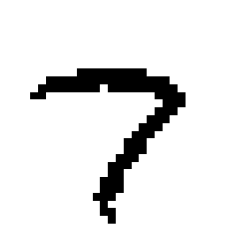

In [6]:
plot_img(train_set[1])


Further on, we will like to get rid parts of the image and reconstruct them.
There is a function for partially removing parts of the image in the test set:

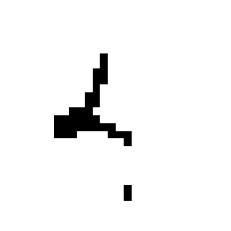

In [6]:
plot_img( partial_removal_img(train_set[1], fraction = .4, axis = 1))

### 2. MPS 

1. Create an MPS network
2. Canonicalize towards the second tensor
3. Rename indexes (in a readable form)

In [7]:
toymps = initialize_mps(Ldim=10, bdim=10)

Inspect shape/canonicalization

In [8]:
toymps.show()

 2 10 10 10 10 10 8 4 2 
>─●──<──<──<──<──<─<─<─<
│ │  │  │  │  │  │ │ │ │


Inspect indexes

In [9]:
toymps.tensors

(Tensor(shape=(2, 2), inds=('i0', 'v0'), tags=oset(['I0'])),
 Tensor(shape=(2, 10, 2), inds=('i0', 'i1', 'v1'), tags=oset(['I1'])),
 Tensor(shape=(10, 10, 2), inds=('i1', 'i2', 'v2'), tags=oset(['I2'])),
 Tensor(shape=(10, 10, 2), inds=('i2', 'i3', 'v3'), tags=oset(['I3'])),
 Tensor(shape=(10, 10, 2), inds=('i3', 'i4', 'v4'), tags=oset(['I4'])),
 Tensor(shape=(10, 10, 2), inds=('i4', 'i5', 'v5'), tags=oset(['I5'])),
 Tensor(shape=(10, 8, 2), inds=('i5', 'i6', 'v6'), tags=oset(['I6'])),
 Tensor(shape=(8, 4, 2), inds=('i6', 'i7', 'v7'), tags=oset(['I7'])),
 Tensor(shape=(4, 2, 2), inds=('i7', 'i9', 'v8'), tags=oset(['I8'])),
 Tensor(shape=(2, 2), inds=('i9', 'v9'), tags=oset(['I9'])))

In [3]:
mps = initialize_mps(bdim=30)

I developed two forms to compute the contraction of the mps and an image 

namely psi(v)

1. (SLOW) actually creates the network of the image and contract it 
2. einsums

the two methods outputs the same result, but the second is way faster

In [11]:
%%time

slow_psi = quimb_transform_img2state(train_set[0]) @ mps

CPU times: user 3.66 s, sys: 3.87 ms, total: 3.66 s
Wall time: 3.66 s


In [12]:
%%time 

fast_psi = computepsi(mps, train_set[0])

CPU times: user 21.4 ms, sys: 222 µs, total: 21.7 ms
Wall time: 19.4 ms


### 3. Learning

In [ ]:
imgs = train_set[:2]
mps = initialize_mps(bdim=30)


In [35]:
# Compute probability of the first image of the training set of the untrained network
computepsi(mps,imgs[0])**2

2.3701908704769463e-253

In [36]:
for epoch in range(3):
    learning_epoch_sgd(mps, imgs, 3, 0.1)


  0%|          | 0/1562 [00:00<?, ?it/s]

  0%|          | 0/1562 [00:00<?, ?it/s]

  0%|          | 0/1562 [00:00<?, ?it/s]

In [37]:
# Compute probability of the first image of the training set of the trained network
computepsi(mps,imgs[0])**2 / mps.norm()


0.38430046322321615

In [38]:
# Compute probability of random noise from the trained network
computepsi(mps,np.random.randint(0,2,(784)) )**2 / mps.norm()

5.101239428870765e-254

In [39]:
computeNLL(mps/mps.norm(), imgs)

5.357394762688644

### 4. Generation

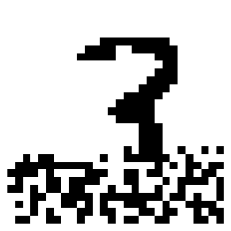

In [12]:
gen = generate_sample(mps)
plot_img(gen)

### 5. MPS Saving and Loading

In [ ]:
quimb.utils.save_to_disk(mps, './testmps')

['./testmps']

In [ ]:
mps = quimb.utils.load_from_disk('./testmps')

In [ ]:
computeNLL(loaded_mps/loaded_mps.norm(), imgs)

5.357394762688636

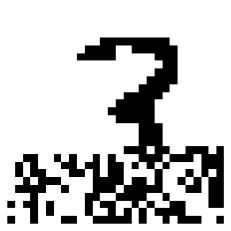

In [ ]:
gen = generate_sample(mps)
plot_img(gen)

### 6. Optimizations

In [4]:
vector = np.random.rand(30,)
tensor = np.random.rand(30,30,10)

tvector = qtn.Tensor(data=vector, inds=('a'))
ttensor = qtn.Tensor(data=tensor, inds=('a','b','c'))

In [24]:
%%timeit
tvector @ ttensor

41.6 µs ± 519 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [25]:
%%timeit

data = np.einsum('a,abc',tvector.data,ttensor.data)

tn = qtn.Tensor(data=data, inds=('b','c'))

5.66 µs ± 92.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [26]:
%%timeit
qtn.tensor_contract(tvector, ttensor, backend='numpy')

39.3 µs ± 630 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [5]:
%%timeit

tneinsum(tvector, ttensor)

6.49 µs ± 33.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [6]:
%%timeit

tneinsum2(tvector, ttensor)

6.6 µs ± 27.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [29]:
%%timeit

data = np.tensordot(tvector.data,ttensor.data, (0,0))

tn = qtn.Tensor(data=data, inds=('b','c'))

14.2 µs ± 318 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


### 7. Cache

In [4]:
mps = initialize_mps()

In [5]:
imgs = train_set[:10]

_imgs = []
for img in imgs:
    _imgs.append( tens_picture(img) )

img_cache = left_right_cache(mps, _imgs)


In [6]:
NLLs = learning_epoch_cached(mps, _imgs, 2, 0.08, img_cache)

NLL: 570.6073830605292 | Baseline: 2.302585092994046
epoch 1/2


  0%|          | 0/1564 [00:00<?, ?it/s]

NLL: 27.306562084258907 | Baseline: 2.302585092994046
epoch 2/2


  0%|          | 0/1564 [00:00<?, ?it/s]

NLL: 10.63495077193076 | Baseline: 2.302585092994046


### 8. Generation and Reconstruction

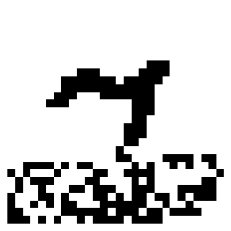

In [7]:
gen = generate_sample(mps)
plot_img(gen)

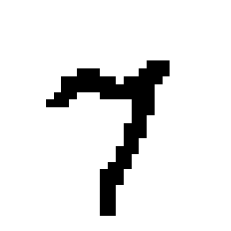

In [13]:
plot_img(train_set[2])

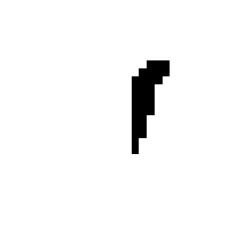

In [14]:
corr_img = partial_removal_img(train_set[2], fraction = .4, axis = 1)
plot_img(corr_img)


In [15]:
recc = reconstruct(mps, corr_img)

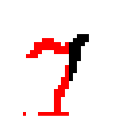

In [16]:
plot_rec(corr_img, recc)